# Testing
### Aufenthaltsart der ausländischen Bevölkerung nach Nationalität und Geschlecht seit 1993

Beschreibung
Diese Daten beschreiben die Aufenthaltsart der ausländischen wirtschaftlichen Wohnbevölkerung nach Nationalität, Region, Kontinent und Geschlecht seit 1993.

Datum: 15.03.2022


### Importiere die notwendigen Packages

In [19]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap

In [1]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns
#import leafmap

import requests
import io


In [2]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [3]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [4]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [5]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [6]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 11 datenstand:  9 time.struct_time(tm_year=2022, tm_mon=11, tm_mday=10, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=3, tm_yday=314, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [7]:
epoch = datetime.datetime(1960, 1, 1)

### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**BITTE HIER ANPASSEN**

In [8]:
package_name = "bev_bestand_jahr_nationalitaet_aufenthaltsart_geschl_od3371"

In [9]:
dataset_name = "BEV337OD3371.csv"

**Statische Pfade in DWH-Dropzones**

In [10]:
dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [11]:
dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [12]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/int_dwh_"

In [13]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [14]:
from IPython.display import Markdown as md

In [15]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_bestand_jahr_nationalitaet_aufenthaltsart_geschl_od3371 

In [16]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

 **2. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_nationalitaet_aufenthaltsart_geschl_od3371 

### Importiere einen Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [18]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "prod"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

prod - web


In [19]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_prod_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_integ_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)


fp lautet:https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_nationalitaet_aufenthaltsart_geschl_od3371/download/BEV337OD3371.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [20]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['StichtagDatJahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['StichtagDatJahr']
        # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
        #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
        ,low_memory=False)
    print("web")

data2betested.dtypes

web


StichtagDatJahr    datetime64[ns]
AufArt2CdAgg                int64
AufArt2LangAgg             object
SexCd                       int64
SexLang                    object
NationHistCd                int64
NationHistLang             object
RegionCd                    int64
RegionLang                 object
KontinentCd                 int64
KontinentLang              object
AnzBestWir                  int64
dtype: object

Berechne weitere Attribute falls notwendig

In [21]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        StichtagDatJahr_str = lambda x: x.StichtagDatJahr.astype(str),
    )
    .sort_values('StichtagDatJahr', ascending=False)
    )
data2betested.dtypes

StichtagDatJahr        datetime64[ns]
AufArt2CdAgg                    int64
AufArt2LangAgg                 object
SexCd                           int64
SexLang                        object
NationHistCd                    int64
NationHistLang                 object
RegionCd                        int64
RegionLang                     object
KontinentCd                     int64
KontinentLang                  object
AnzBestWir                      int64
StichtagDatJahr_str            object
dtype: object

### Einfache Datentests

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [22]:
data2betested.head(2)

,StichtagDatJahr,AufArt2CdAgg,AufArt2LangAgg,SexCd,SexLang,NationHistCd,NationHistLang,RegionCd,RegionLang,KontinentCd,KontinentLang,AnzBestWir,StichtagDatJahr_str
22631,2021-01-01,3,Übrige,2,weiblich,8999,Staat unbekannt,88,Unzuteilbar,8,Unzuteilbar,16,2021-01-01
22086,2021-01-01,1,Niedergelassene (C),2,weiblich,8529,Nepal,46,Südasien,4,Asien,5,2021-01-01


In [23]:
data2betested.dtypes

StichtagDatJahr        datetime64[ns]
AufArt2CdAgg                    int64
AufArt2LangAgg                 object
SexCd                           int64
SexLang                        object
NationHistCd                    int64
NationHistLang                 object
RegionCd                        int64
RegionLang                     object
KontinentCd                     int64
KontinentLang                  object
AnzBestWir                      int64
StichtagDatJahr_str            object
dtype: object

In [24]:
data2betested.shape

(22632, 13)

Beschreibe einzelne Attribute

In [25]:
data2betested.describe()

,AufArt2CdAgg,SexCd,NationHistCd,RegionCd,KontinentCd,AnzBestWir
count,22632,22632,22632,22632,22632,22632
mean,2,1,8379,29,2,150
std,1,0,137,14,1,640
min,1,1,8201,11,1,0
25%,1,1,8256,17,1,3
50%,2,1,8350,24,2,16
75%,3,2,8507,42,4,66
max,3,2,8999,88,8,11453


Wie viele Nullwerte gibt es im Datensatz?

In [26]:
data2betested.isnull().sum()

StichtagDatJahr        0
AufArt2CdAgg           0
AufArt2LangAgg         0
SexCd                  0
SexLang                0
NationHistCd           0
NationHistLang         0
RegionCd               0
RegionLang             0
KontinentCd            0
KontinentLang          0
AnzBestWir             0
StichtagDatJahr_str    0
dtype: int64

Welches sind die Quartiere ohne Werte bei AnzBestWir?

In [27]:
data2betested[np.isnan(data2betested.AnzBestWir)]

,StichtagDatJahr,AufArt2CdAgg,AufArt2LangAgg,SexCd,SexLang,NationHistCd,NationHistLang,RegionCd,RegionLang,KontinentCd,KontinentLang,AnzBestWir,StichtagDatJahr_str


### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [28]:
data2betested = data2betested.set_index("StichtagDatJahr")

In [29]:
data2betested.info()
data2betested.index.year.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22632 entries, 2021-01-01 to 1993-01-01
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   AufArt2CdAgg         22632 non-null  int64 
 1   AufArt2LangAgg       22632 non-null  object
 2   SexCd                22632 non-null  int64 
 3   SexLang              22632 non-null  object
 4   NationHistCd         22632 non-null  int64 
 5   NationHistLang       22632 non-null  object
 6   RegionCd             22632 non-null  int64 
 7   RegionLang           22632 non-null  object
 8   KontinentCd          22632 non-null  int64 
 9   KontinentLang        22632 non-null  object
 10  AnzBestWir           22632 non-null  int64 
 11  StichtagDatJahr_str  22632 non-null  object
dtypes: int64(6), object(6)
memory usage: 2.2+ MB


Int64Index([2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008,
            2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994,
            1993],
           dtype='int64', name='StichtagDatJahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [30]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [31]:
data2betested.loc["2009"].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,AufArt2CdAgg,AufArt2LangAgg,SexCd,SexLang,NationHistCd,NationHistLang,RegionCd,RegionLang,KontinentCd,KontinentLang,AnzBestWir,StichtagDatJahr_str
StichtagDatJahr,,,,,,,,,,,,
2009-01-01,1,Niedergelassene (C),2,weiblich,8546,Bangladesch,46,Südasien,4,Asien,64,2009-01-01
2009-01-01,1,Niedergelassene (C),2,weiblich,8607,Neuseeland,56,Südliches Ozeanien,5,Ozeanien,8,2009-01-01


### Visualisierungen nach Zeitausschnitten

In [32]:
data2betested.columns

Index(['AufArt2CdAgg', 'AufArt2LangAgg', 'SexCd', 'SexLang', 'NationHistCd', 'NationHistLang',
       'RegionCd', 'RegionLang', 'KontinentCd', 'KontinentLang', 'AnzBestWir',
       'StichtagDatJahr_str'],
      dtype='object')

#### Entwicklung Wohnbevölkerung nach Aufenthaltsart

In [33]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["1993":"2021"]\
    .groupby(['StichtagDatJahr', 'AufArt2CdAgg', 'AufArt2LangAgg']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg.reset_index().head(3)

,StichtagDatJahr,AufArt2CdAgg,AufArt2LangAgg,sum_WBev


In [34]:
myTitle="Wohnbevölkerung nach Altersgruppe"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['AufArt2LangAgg'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_WBev>10'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('AufArt2LangAgg', legend=alt.Legend(title="Altersgruppen", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'AufArt2LangAgg','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

C:\Users\sszsim\AppData\Local\Continuum\anaconda3\lib\site-packages\altair\utils\core.py:185: UserWarning: I don't know how to infer vegalite type from 'empty'.  Defaulting to nominal.
  warnings.warn(


alt.LayerChart(...)

#### Barcharts mit Seaborn

##### Entwicklung nach Aufenthaltsart und Herkunftsregion

In [35]:
myAggBar =  data2betested.loc["1993":"2021"]\
    .groupby(['StichtagDatJahr', 'AufArt2CdAgg', 'AufArt2LangAgg','StichtagDatJahr_str']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAggBar.reset_index().head(3)

,StichtagDatJahr,AufArt2CdAgg,AufArt2LangAgg,StichtagDatJahr_str,sum_WBev


In [36]:
#help(sns.catplot)     

In [37]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

In [38]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="StichtagDatJahr_str"
            , y="sum_WBev"
            , hue="AufArt2LangAgg"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index()
           )
myHist.set_xlabels('Zeit', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Pers.', fontsize=11)


ValueError: min() arg is an empty sequence

In [ ]:
#data2betested.dtypes

In [39]:
myAggBar = data2betested\
    .groupby(['StichtagDatJahr', 'AufArt2CdAgg', 'AufArt2LangAgg','RegionCd', 'RegionLang','StichtagDatJahr_str']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

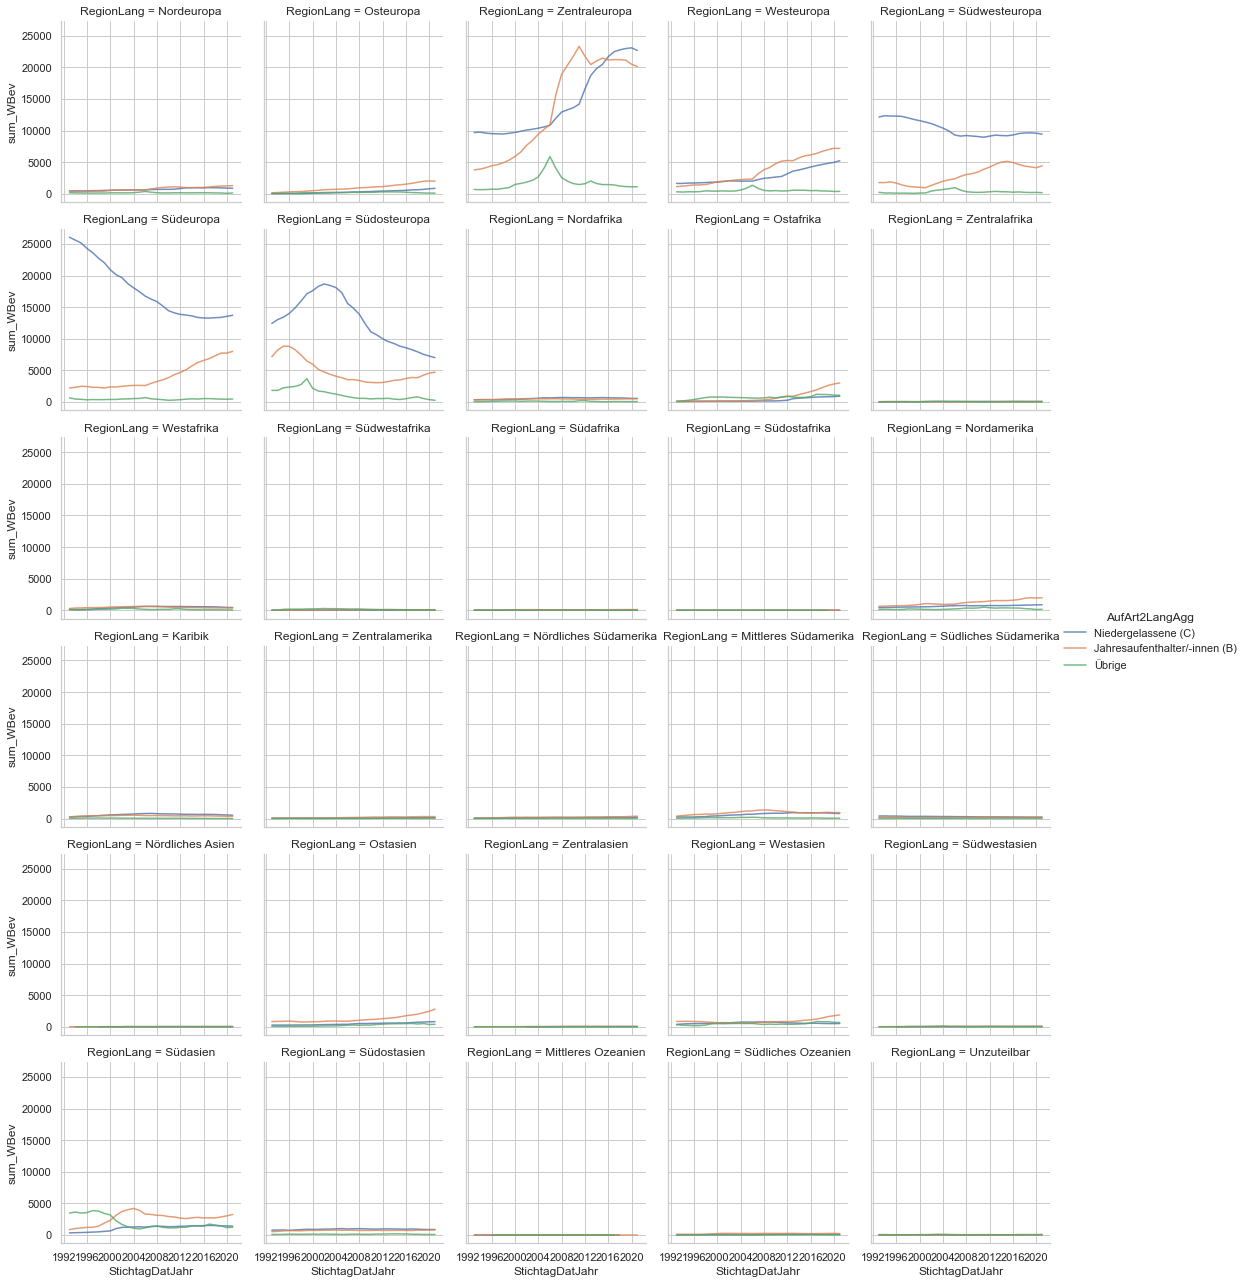

In [40]:
#g = sns.FacetGrid(myAggBar.reset_index(), col="QuarLang", hue="HerkunftLang", col_wrap=6, height=3,)
#g.map(sns.scatterplot, "AlterV05Sort", "sum_WBev", alpha=.8)
#g.add_legend()

g2 = sns.FacetGrid(myAggBar.reset_index().sort_values('RegionCd',ascending=True), col="RegionLang", hue="AufArt2LangAgg", col_wrap=5, height=3,)
g2.map(sns.lineplot, "StichtagDatJahr","sum_WBev",alpha=.8)

g2.add_legend()


### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Aktueller Bestand der WBev nach Aufenthaltsstatus, Kontinent, Nation und Geschlecht, 2021

In [41]:
data2betested.columns

Index(['AufArt2CdAgg', 'AufArt2LangAgg', 'SexCd', 'SexLang', 'NationHistCd', 'NationHistLang',
       'RegionCd', 'RegionLang', 'KontinentCd', 'KontinentLang', 'AnzBestWir',
       'StichtagDatJahr_str'],
      dtype='object')

In [42]:
myTreemapAgg = data2betested.loc["2021"]  \
    .groupby(['AufArt2CdAgg', 'AufArt2LangAgg','KontinentCd', 'KontinentLang', 'SexCd', 'SexLang', 'NationHistCd', 'NationHistLang']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('sum_WBev', ascending=True) 

myTreemapAgg.reset_index().head(3)

,AufArt2CdAgg,AufArt2LangAgg,KontinentCd,KontinentLang,SexCd,SexLang,NationHistCd,NationHistLang,sum_WBev
0,1,Niedergelassene (C),2,Afrika,1,männlich,8311,Gabun,0
1,2,Jahresaufenthalter/-innen (B),2,Afrika,2,weiblich,8337,Burkina Faso,1
2,3,Übrige,2,Afrika,2,weiblich,8341,Ruanda,1


In [45]:
myTitle="Aktueller Bestand der WBev nach Aufenthaltsstatus, Kontinent, Nation und Geschlecht, 2021"

fig = px.treemap(myTreemapAgg.reset_index().query('sum_WBev > 0'), path=[px.Constant(myTitle)
                                                   ,'AufArt2LangAgg', 'KontinentLang', 'SexLang', 'NationHistLang']
                 , values='sum_WBev'
                 , color='sum_WBev'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='Blues'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=600
                 ,width=1200                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [46]:
myTitle="Aktueller Bestand der WBev nach Aufenthaltsstatus, Kontinent, Nation und Geschlecht, 2021"

fig = px.treemap(myTreemapAgg.reset_index().query('sum_WBev > 0'), path=[px.Constant(myTitle)
                                                   ,'AufArt2LangAgg', 'KontinentLang', 'SexLang', 'NationHistLang']
                 , values='sum_WBev'
                 , color='NationHistLang'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 , color_discrete_map={'(?)':'lightgrey','Deutschland':'gold', 'Spanien':'#FF3030', 'Serbien':'#EE3B3B', 'Frankreich':'#A2CD5A','Kosovo':'#CAFF70','Grossbritanien':'orange','Italien':'#104E8B','Ungarn':'deeppink','SVP':'Österreich', 'USA':'#8B864E','Griechenland':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='Blues'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=600
                 ,width=1200                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

## ---------------------- hier Plausi beendet

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=397&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

---------------------------------------------------------------------------